# Bank Marketing Term Deposit Prediction

Rebuilt notebook covering data cleaning, preprocessing, feature selection, model comparison, hyperparameter tuning, evaluation, and export of a deployable pipeline for Streamlit.


In [ ]:
import json
import joblib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RANDOM_STATE = 42
DATA_PATH = Path('bank-additional.csv')
ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)



In [40]:
# Load data

df = pd.read_csv(DATA_PATH, sep=';')
print('Shape:', df.shape)
print('\nPreview:')
display(df.head())

print('\nTarget distribution:')
print(df['y'].value_counts(normalize=True).rename('proportion'))


Shape: (4119, 21)

Preview:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no



Target distribution:
y
no     0.890507
yes    0.109493
Name: proportion, dtype: float64


In [ ]:
# Basic cleaning: treat 'unknown' as missing for categorical cols

df_clean = df.copy()
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('y')
for col in cat_cols:
    df_clean[col] = df_clean[col].replace('unknown', np.nan)

# --- Feature engineering: pdays handling ---
# Flag whether the client was contacted before; 999 means never contacted
# Replace pdays=999 with -1 to avoid misleading distance for models
if 'pdays' in df_clean.columns:
    df_clean['was_contacted'] = np.where(df_clean['pdays'] == 999, 0, 1)
    df_clean['pdays'] = df_clean['pdays'].replace(999, -1)

print('Missing values after marking unknowns and pdays tweaks:')
print(df_clean.isna().sum())



Missing values after marking unknowns:
age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64


In [42]:
# Train/test split

X = df_clean.drop(columns=['y'])
y = df_clean['y'].map({'no': 0, 'yes': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)



Train size: (3295, 20) Test size: (824, 20)


In [ ]:
# Preprocessing + feature selection

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)

selector = SelectKBest(mutual_info_classif, k=30)



In [ ]:
# Compare baseline models via ROC-AUC (with class weights for imbalance)

models = {
    # Logistic Regression already balanced
    'log_reg': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    # Add class weights to emphasize the minority class
    'rf': RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    'gboost': GradientBoostingClassifier(random_state=RANDOM_STATE),
    # MLP does not natively take class_weight; keep as-is
    'mlp': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=RANDOM_STATE),
}

# Optional: add XGBoost if installed (better imbalance handling via scale_pos_weight)
try:
    from xgboost import XGBClassifier

    models['xgboost'] = XGBClassifier(
        scale_pos_weight=9,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False,
    )
    print('XGBoost eklendi.')
except ImportError:
    print('XGBoost kütüphanesi bulunamadı, mevcut modellerle devam ediliyor.')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('preprocess', preprocess),
        ('selector', selector),
        ('clf', clf),
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = {'roc_auc_mean': scores.mean(), 'roc_auc_std': scores.std()}

results_df = pd.DataFrame(results).T.sort_values('roc_auc_mean', ascending=False)
print(results_df)
best_name = results_df.index[0]
print('\nBest baseline model:', best_name)



         roc_auc_mean  roc_auc_std
gboost       0.933189     0.014569
log_reg      0.931129     0.013418
rf           0.919128     0.013026
mlp          0.900674     0.014199

Best baseline model: gboost


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

In [45]:
# Hyperparameter tuning for the best baseline

base_clf = models[best_name]

param_distributions = {}
if best_name == 'log_reg':
    param_distributions = {
        'clf__C': np.logspace(-2, 2, 10),
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'liblinear'],
    }
elif best_name == 'rf':
    param_distributions = {
        'clf__n_estimators': [100, 200, 400],
        'clf__max_depth': [None, 5, 10, 20],
        'clf__max_features': ['auto', 'sqrt', 0.5],
        'clf__min_samples_split': [2, 5, 10],
    }
elif best_name == 'gboost':
    param_distributions = {
        'clf__n_estimators': [100, 200, 400],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [2, 3, 4],
    }
else:  # mlp
    param_distributions = {
        'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'clf__alpha': [1e-4, 1e-3, 1e-2],
        'clf__learning_rate_init': [0.001, 0.01],
    }

search_pipe = Pipeline([
    ('preprocess', preprocess),
    ('selector', selector),
    ('clf', base_clf),
])

search = RandomizedSearchCV(
    search_pipe,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

search.fit(X_train, y_train)
print('Best params:', search.best_params_)
print('Best CV ROC-AUC:', search.best_score_)

best_model = search.best_estimator_



Best params: {'clf__n_estimators': 100, 'clf__max_depth': 2, 'clf__learning_rate': 0.05}
Best CV ROC-AUC: 0.9337660107909613


ROC-AUC: 0.9411217075386014
F1: 0.5228758169934641

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       734
           1       0.63      0.44      0.52        90

    accuracy                           0.91       824
   macro avg       0.78      0.71      0.74       824
weighted avg       0.90      0.91      0.90       824



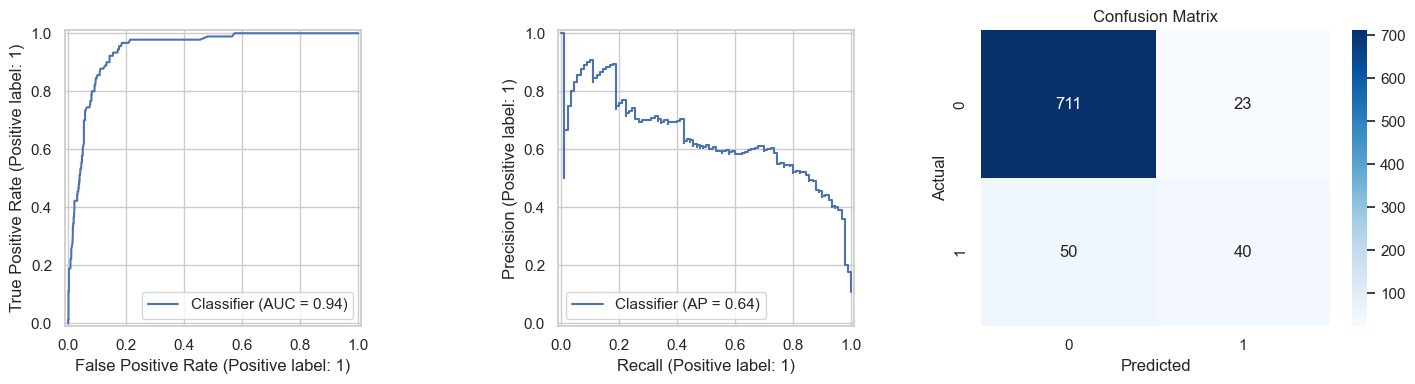

In [46]:
# Evaluation on hold-out test set

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
print('ROC-AUC:', roc_auc)
print('F1:', f1)
print('\nClassification report:\n', classification_report(y_test, y_pred))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0])
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[1])
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Confusion Matrix')
plt.tight_layout()
plt.show()



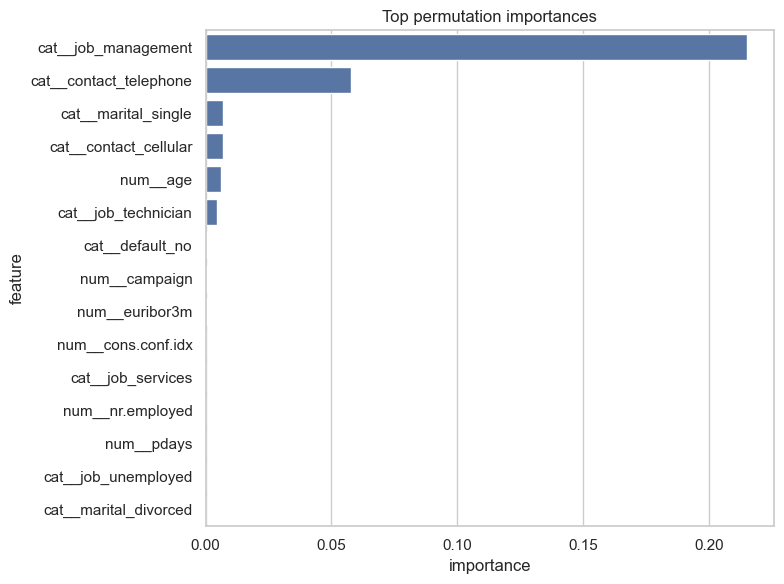

In [48]:
# Feature importance via permutation importance on test set

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)

# Map back to feature names after preprocessing/selection
feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
selected_mask = best_model.named_steps['selector'].get_support()
selected_features = feature_names[selected_mask]

# Align lengths in case of any mismatch
n = min(len(selected_features), len(perm.importances_mean))
importances = pd.DataFrame({
    'feature': selected_features[:n],
    'importance': perm.importances_mean[:n]
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=importances, y='feature', x='importance')
plt.title('Top permutation importances')
plt.tight_layout()
plt.show()



In [49]:
# Persist model and metrics for Streamlit

MODEL_PATH = ARTIFACT_DIR / 'final_model.pkl'
METRICS_PATH = ARTIFACT_DIR / 'metrics.json'

joblib.dump(best_model, MODEL_PATH)
metrics = {
    'roc_auc': float(roc_auc),
    'f1': float(f1),
    'best_params': search.best_params_,
    'best_model': best_name,
}
METRICS_PATH.write_text(json.dumps(metrics, indent=2))

print('Saved model to', MODEL_PATH)
print('Saved metrics to', METRICS_PATH)



Saved model to artifacts/final_model.pkl
Saved metrics to artifacts/metrics.json
